In [1]:
import re
import os
import numpy as np
import pandas as pd
import random
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score,mean_absolute_percentage_error
from mllib.model import KerasSurrogate
from helper_functions.scan_helper_functions import AdjustedRSquared
from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
from helper_functions.invertible_neural_network import InvertibleNetworkSurrogate


In [2]:
class AdjustedRSquaredSeparated(tf.keras.losses.Loss):
    '''
    Calculates the adjusted R^2 value for each predicted quantity separately.

    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self, batch_size, number_of_input):
        '''
        Parameters
        ==========
        batch_size: int
            Number of samples in a batch,
            i. e. number of rows of a batch of the X matrix.
        number_of_input: int
            Number of independent variables (=columns) in the problem,
            i. e. number of columns of the X matrix.
        '''
        super().__init__(name='adjusted_r2')
        self._n = batch_size
        self._n_in = number_of_input

    def call(self, y_true, y_pred):
        r2 = RSquaredSeparated().call(y_true, y_pred)

        adjusted_r2 = 1. - (1. - r2) * (self._n - 1.) / (self._n - self._n_in - 1.)

        return adjusted_r2

    @classmethod
    def from_config(cls, config):
        return AdjustedRSquaredSeparated(config['n'], config['n_in'])

    def get_config(self):
        return {
            'n': self._n,
            'n_in': self._n_in,
        }

In [3]:
class RSquaredSeparated(tf.keras.losses.Loss):
    '''
    Calculates the R^2 value for each predicted quantity separately.

    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self):
        super().__init__(name='r2')

    def call(self, y_true, y_pred):
        mean_true = tf.math.reduce_mean(y_true, axis=0)

        total_sum_of_squares = tf.math.reduce_sum(tf.math.squared_difference(y_true, mean_true),
                                                  axis=0)
        
        residual_sum_of_squares = tf.math.reduce_sum(tf.math.squared_difference(y_true, y_pred),
                                                     axis=0)
        r2 = 1. - residual_sum_of_squares / total_sum_of_squares

        return r2

In [4]:
class AdjustedRSquared(tf.keras.losses.Loss):
    '''
    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self, batch_size, number_of_input):
        '''
        Parameters
        ==========
        batch_size: int
            Number of samples in a batch,
            i. e. number of rows of a batch of the X matrix.
        number_of_input: int
            Number of independent variables (=columns) in the problem,
            i. e. number of columns of the X matrix.
        '''
        super().__init__(name='adjusted_r2')
        self._n = batch_size
        self._n_in = number_of_input

    def call(self, y_true, y_pred):
        r2 = RSquared().call(y_true, y_pred)

        adjusted_r2 = 1. - (1. - r2) * (self._n - 1.) / (self._n - self._n_in - 1.)
        adjusted_r2 = tf.math.reduce_mean(adjusted_r2)

        return adjusted_r2

    @classmethod
    def from_config(cls, config):
        return AdjustedRSquared(config['n'], config['n_in'])

    def get_config(self):
        return {
            'n': self._n,
            'n_in': self._n_in,
        }

Median radius ~ 400 nm
Ln(GSD) ~ 0.262
V ~ 24.5 um3/cc
DEHS particles (refractive index = 1.45 + 1e-5i at 532 nm)

These results are for different median size cases, namely, 200 nm, 400 nm, 600 nm and 800 nm. I included another CSV file that has the average number concentration with unit of #/cc. The GSD for these experiment are not exactly known but it is most likely between 1.05 to 1.1. Note that the unit for phase function is 1/Mm 1/str.

n addition to these narrow phase function data, I included another CSV file that has the phase function for a measurement conducted for broad size distribution with median size of 400 nm and GSD 1.4. This could already be included in the current ML model as its GSD is within the training range. Note that both phase function (P11) and polarized phase function (PPF) are include in the same csv file for the broad 400 nm data.
 
 

In [5]:
np.exp(0.262)

1.2995265424293818

# Open Data

In [6]:
seed = 49857
tf.random.set_seed(seed)
np.random.seed(seed)

In [7]:
directory1 = '/data/project/general/aerosolretriev'

In [10]:
#plot_dir = directory1 + 'version13/plots/measurement_data'
#if not os.path.exists(plot_dir):
#    os.makedirs(plot_dir)



In [11]:
#model_dir = '/data/project/general/aerosolretriev/aerosol_results_ds08/aerosol_results_11_09_2022/forward_model2/models/forward_model'


#model_dir = '/data/project/general/aerosolretriev/aerosol_results_september_2022/forward_models/forward_model08/forward_id/train_forward_model_6634c_00000_0_2022-09-22_08-54-27'
model_dir = '/data/project/general/aerosolretriev/aerosol_results_20october_2022/invertible_model0/models'


In [12]:
custom_objects = {
    'AdjustedRSquared': AdjustedRSquared,
}

kwargs = {
    'custom_objects': custom_objects,
    'compile': False,
}
model_name = 'invertible_model'

custom_objects = {'AdjustedRSquared': AdjustedRSquared}

kwargs = {'custom_objects': custom_objects,'compile': False}

surr = InvertibleNetworkSurrogate.load(model_dir, model_name, model_kwargs=kwargs)

In [13]:

#surr = keras.models.load_model(model_dir)


#Load test data

In [15]:
test_datafile = '/data/project/general/aerosolretriev/aerosol_data/dataset_20_10_2022/data_all_train_iv.h5'
dvar_test = pd.read_hdf(test_datafile,key = 'dvar')
qoi_test = pd.read_hdf(test_datafile,key = 'qoi')


Real measurement data

In [16]:
data_dir = '/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_Alireza_Phdthesis'

#phase_fun400_old = pd.read_csv(data_dir2+"/uNeph_PF_400nm_broad.csv")
#num_con = pd.read_csv(data_dir1+"/number_concentration.csv")
phase_fun_meas = pd.read_csv(data_dir+"/df_p11_ppf_uNeph.csv")
phase_fun_GRASP_inv = pd.read_csv(data_dir+"/df_p11_ppf_grasp.csv")
vol_size_GRASP_bin = pd.read_csv(data_dir+"/df_psd_grasp_binned.csv")
vol_size_GRASP_log = pd.read_csv(data_dir+"/df_psd_grasp_lognorm.csv")
vol_size_meas = pd.read_csv(data_dir+"/df_psd_smps.csv")
meas_param = pd.read_csv(data_dir+"/df_measured_and_retreived_psd_properties.csv")
#phase_fun400_bin = pd.read_csv(data_dir+"/df_PF_Grasp_binned_P11P12_1wl.csv")

#data_real_old = pd.read_csv(data_dir2+"/uNeph_GRASP_data.csv")

#"/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_november2021/df_PF_Grasp_binned_P11P12_1wl.csv"



#phase_fun400_log = pd.read_csv(data_dir+"/df_PF_Grasp_lognorm_P11P12_1wl.csv")

#phase_funexp = pd.read_csv(data_dir+"/phase_function_experimental_data.csv")
#phase_funP11 = pd.read_csv(data_dir+"/phase_function_P11.csv")
#phase_funpolar = pd.read_csv(data_dir+'/polar_phase_function.csv')

In [17]:
phase_fun_meas.head(12)

angles         P11       PPF
0    2.958415         NaN       NaN
1    3.939364         NaN       NaN
2    4.917770  183.301344  0.000434
3    5.893669  188.270193 -0.016319
4    6.867099  211.998636  0.017256
5    7.838099         NaN       NaN
6    8.806713         NaN       NaN
7    9.772985         NaN       NaN
8   10.736964         NaN       NaN
9   11.698698  173.001017  0.047280
10  12.658239  167.585850  0.030640
11  13.615641  165.624263  0.009350

In [18]:
phase_fun_GRASP_inv

angle  P11_Binned (0.05-15$\mu$m)_P11P12  \
0     11.698698                         184.723185   
1     12.658239                         179.542691   
2     13.615641                         174.346282   
3     16.475578                         157.690718   
4     17.424998                         151.905435   
..          ...                                ...   
151  165.388185                           2.294616   
152  166.410092                           2.346023   
153  167.435464                           2.398624   
154  168.464287                           2.451782   
155  169.496541                           2.504621   

     PPF_Binned (0.05-15$\mu$m)_P11P12  P11_Binned (0.05-15$\mu$m)_P11  \
0                             0.002964                      182.797410   
1                             0.003433                      176.351635   
2                             0.003926                      170.120719   
3                             0.005515                      151.682619   
4                             0.006071                      145.730224   
..                                 ...                             ...   
151                          -0.239340                        2.482260   
152                          -0.211780                        2.491332   
153                          -0.184640                        2.501677   
154                          -0.158310                        2.515523   
155                          -0.133180                        2.535020   

     P11_lognormal (0.05-15$\mu$m)_P11P12  \
0                              187.046847   
1                              181.643537   
2                              176.224311   
3                              158.916211   
4                              152.908112   
..                                    ...   
151                              2.304802   
152                              2.356528   
153                              2.409685   
154                              2.463639   
155                              2.517592   

     PPF_lognormal (0.05-15$\mu$m)_P11P12  P11_lognormal (0.05-15$\mu$m)_P11  
0                                0.002702                         186.227199  
1                                0.003125                         180.911424  
2                                0.003571                         175.579733  
3                                0.005000                         158.510366  
4                                0.005496                         152.581844  
..                                    ...                                ...  
151                             -0.246980                           2.299709  
152                             -0.218910                           2.351355  
153                             -0.191120                           2.404433  
154                             -0.164070                           2.458148  
155                             -0.138160                           2.511624  

[156 rows x 7 columns]

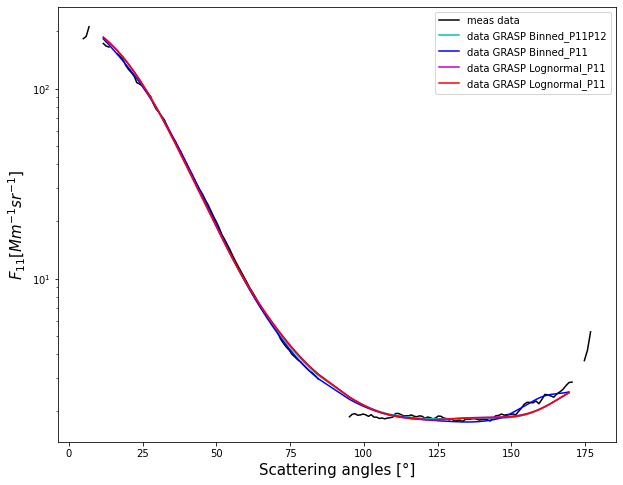

In [19]:
fontsize1 = 15
plt.figure(figsize= (10,8))
plt.plot(phase_fun_meas['angles'],phase_fun_meas['P11'],'k',label = 'meas data')
plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_Binned (0.05-15$\mu$m)_P11P12'],'c',label = 'data GRASP Binned_P11P12')
plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_Binned (0.05-15$\mu$m)_P11'],'b',label = 'data GRASP Binned_P11')
plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_lognormal (0.05-15$\mu$m)_P11P12'],'m',label = 'data GRASP Lognormal_P11')
plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_lognormal (0.05-15$\mu$m)_P11'],'r',label = 'data GRASP Lognormal_P11')


plt.yscale('log')

plt.xlabel('Scattering angles [°]', fontsize = fontsize1)
plt.ylabel('$F_{11} [Mm^{-1}sr^{-1}$]', fontsize = fontsize1)
plt.legend()


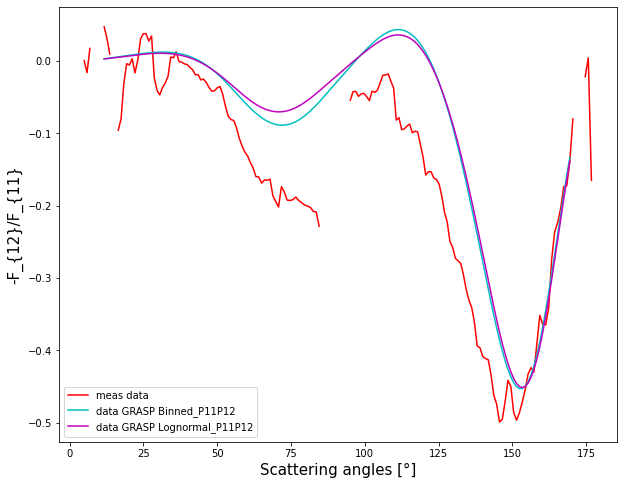

In [20]:
fontsize1 = 15
plt.figure(figsize= (10,8))
plt.plot(phase_fun_meas['angles'],phase_fun_meas['PPF'],'r',label = 'meas data')
plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['PPF_Binned (0.05-15$\mu$m)_P11P12'],'c',label = 'data GRASP Binned_P11P12')
plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['PPF_lognormal (0.05-15$\mu$m)_P11P12'],'m',label = 'data GRASP Lognormal_P11P12')


plt.xlabel('Scattering angles [°]', fontsize = fontsize1)
plt.ylabel('-F_{12}/F_{11}', fontsize = fontsize1)
plt.legend()

# transform real measurement data to right format

In [21]:
# First step: interpolate the angles

In [22]:
from scipy.interpolate import interp1d

In [23]:
phase_fun_meas['angles'].max()

176.8157278691418

In [24]:
f_11 = interp1d(phase_fun_meas['angles'],phase_fun_meas['P11'])
f_PPF = interp1d(phase_fun_meas['angles'],phase_fun_meas['PPF'])
#f_11_GRASP = interp1d(data_real['angles'],data_real['P11_GRASP_lognorm'])
#f_12_GRASP = interp1d(data_real['angles'],data_real['PPF_GRASP_lognorm'])

In [25]:
angles_meas_new = np.linspace(3,176,num = 174,endpoint = True)
angles_meas_new

array([  3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,
        14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,
        25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
        36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,
        47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,
        58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,
        69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,
        80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,
        91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101.,
       102., 103., 104., 105., 106., 107., 108., 109., 110., 111., 112.,
       113., 114., 115., 116., 117., 118., 119., 120., 121., 122., 123.,
       124., 125., 126., 127., 128., 129., 130., 131., 132., 133., 134.,
       135., 136., 137., 138., 139., 140., 141., 142., 143., 144., 145.,
       146., 147., 148., 149., 150., 151., 152., 15

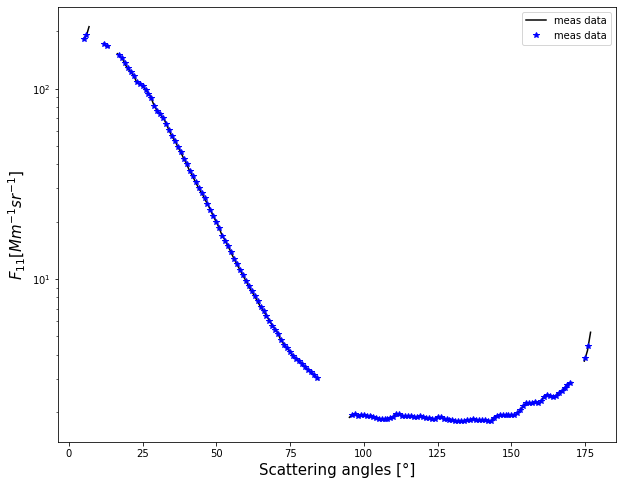

In [26]:
fontsize1 = 15
plt.figure(figsize= (10,8))
plt.plot(phase_fun_meas['angles'],phase_fun_meas['P11'],'k',label = 'meas data')
plt.plot(angles_meas_new,f_11(angles_meas_new),'b*',label = 'meas data')

#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_Binned (0.05-15$\mu$m)_P11P12'],'c',label = 'data GRASP Binned_P11P12')
#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_Binned (0.05-15$\mu$m)_P11'],'b',label = 'data GRASP Binned_P11')
#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_lognormal (0.05-15$\mu$m)_P11P12'],'m',label = 'data GRASP Lognormal_P11')
#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_lognormal (0.05-15$\mu$m)_P11'],'r',label = 'data GRASP Lognormal_P11')


plt.yscale('log')

plt.xlabel('Scattering angles [°]', fontsize = fontsize1)
plt.ylabel('$F_{11} [Mm^{-1}sr^{-1}$]', fontsize = fontsize1)
plt.legend()


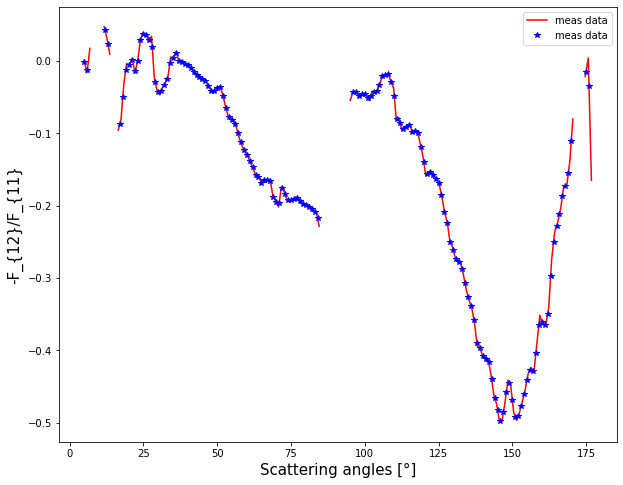

In [27]:
fontsize1 = 15
plt.figure(figsize= (10,8))
plt.plot(phase_fun_meas['angles'],phase_fun_meas['PPF'],'r',label = 'meas data')
plt.plot(angles_meas_new,f_PPF(angles_meas_new),'b*',label = 'meas data')

#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['PPF_Binned (0.05-15$\mu$m)_P11P12'],'c',label = 'data GRASP Binned_P11P12')
#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['PPF_lognormal (0.05-15$\mu$m)_P11P12'],'m',label = 'data GRASP Lognormal_P11P12')


plt.xlabel('Scattering angles [°]', fontsize = fontsize1)
plt.ylabel('-F_{12}/F_{11}', fontsize = fontsize1)
plt.legend()

In [28]:
# Bringing the data in the right format

In [29]:
phase_fun_meas_form_F11 = pd.DataFrame(data = f_11(angles_meas_new)).transpose()
phase_fun_meas_form_PPF = pd.DataFrame(data = f_PPF(angles_meas_new)).transpose()


In [30]:
# Rename the columns
listindex_data1 = []
listindex_data2 = []
for i in range(len(angles_meas_new)):
    listindex_data1.append("F11_"+str(int(angles_meas_new[i])))
    listindex_data2.append("PPF_"+str(int(angles_meas_new[i])))

In [31]:
listindex_data1

['F11_3',
 'F11_4',
 'F11_5',
 'F11_6',
 'F11_7',
 'F11_8',
 'F11_9',
 'F11_10',
 'F11_11',
 'F11_12',
 'F11_13',
 'F11_14',
 'F11_15',
 'F11_16',
 'F11_17',
 'F11_18',
 'F11_19',
 'F11_20',
 'F11_21',
 'F11_22',
 'F11_23',
 'F11_24',
 'F11_25',
 'F11_26',
 'F11_27',
 'F11_28',
 'F11_29',
 'F11_30',
 'F11_31',
 'F11_32',
 'F11_33',
 'F11_34',
 'F11_35',
 'F11_36',
 'F11_37',
 'F11_38',
 'F11_39',
 'F11_40',
 'F11_41',
 'F11_42',
 'F11_43',
 'F11_44',
 'F11_45',
 'F11_46',
 'F11_47',
 'F11_48',
 'F11_49',
 'F11_50',
 'F11_51',
 'F11_52',
 'F11_53',
 'F11_54',
 'F11_55',
 'F11_56',
 'F11_57',
 'F11_58',
 'F11_59',
 'F11_60',
 'F11_61',
 'F11_62',
 'F11_63',
 'F11_64',
 'F11_65',
 'F11_66',
 'F11_67',
 'F11_68',
 'F11_69',
 'F11_70',
 'F11_71',
 'F11_72',
 'F11_73',
 'F11_74',
 'F11_75',
 'F11_76',
 'F11_77',
 'F11_78',
 'F11_79',
 'F11_80',
 'F11_81',
 'F11_82',
 'F11_83',
 'F11_84',
 'F11_85',
 'F11_86',
 'F11_87',
 'F11_88',
 'F11_89',
 'F11_90',
 'F11_91',
 'F11_92',
 'F11_93',
 'F11_

In [32]:
phase_fun_meas

angles         P11       PPF
0      2.958415         NaN       NaN
1      3.939364         NaN       NaN
2      4.917770  183.301344  0.000434
3      5.893669  188.270193 -0.016319
4      6.867099  211.998636  0.017256
..          ...         ...       ...
170  172.613621         NaN       NaN
171  173.659308         NaN       NaN
172  174.708254    3.704716 -0.021855
173  175.760413    4.199440  0.004090
174  176.815728    5.250858 -0.165046

[175 rows x 3 columns]

In [33]:
phase_fun_meas_form_F11

0    1           2           3    4    5    6    7    8           9    ...  \
0  NaN  NaN  183.720022  190.862121  NaN  NaN  NaN  NaN  NaN  171.300619  ...   

        164       165       166       167  168  169  170  171       172  \
0  2.580855  2.679499  2.789323  2.848783  NaN  NaN  NaN  NaN  3.841895   

        173  
0  4.438143  

[1 rows x 174 columns]

In [34]:
dicts_data_1 = {}
j = 0
for i in phase_fun_meas_form_F11.columns:
    dicts_data_1[i]=listindex_data1[j]
    j=j+1
dicts_data_2 = {}
j = 0
for i in phase_fun_meas_form_PPF.columns:
    dicts_data_2[i]=listindex_data2[j]
    j=j+1

In [35]:
dicts_data_1

{0: 'F11_3',
 1: 'F11_4',
 2: 'F11_5',
 3: 'F11_6',
 4: 'F11_7',
 5: 'F11_8',
 6: 'F11_9',
 7: 'F11_10',
 8: 'F11_11',
 9: 'F11_12',
 10: 'F11_13',
 11: 'F11_14',
 12: 'F11_15',
 13: 'F11_16',
 14: 'F11_17',
 15: 'F11_18',
 16: 'F11_19',
 17: 'F11_20',
 18: 'F11_21',
 19: 'F11_22',
 20: 'F11_23',
 21: 'F11_24',
 22: 'F11_25',
 23: 'F11_26',
 24: 'F11_27',
 25: 'F11_28',
 26: 'F11_29',
 27: 'F11_30',
 28: 'F11_31',
 29: 'F11_32',
 30: 'F11_33',
 31: 'F11_34',
 32: 'F11_35',
 33: 'F11_36',
 34: 'F11_37',
 35: 'F11_38',
 36: 'F11_39',
 37: 'F11_40',
 38: 'F11_41',
 39: 'F11_42',
 40: 'F11_43',
 41: 'F11_44',
 42: 'F11_45',
 43: 'F11_46',
 44: 'F11_47',
 45: 'F11_48',
 46: 'F11_49',
 47: 'F11_50',
 48: 'F11_51',
 49: 'F11_52',
 50: 'F11_53',
 51: 'F11_54',
 52: 'F11_55',
 53: 'F11_56',
 54: 'F11_57',
 55: 'F11_58',
 56: 'F11_59',
 57: 'F11_60',
 58: 'F11_61',
 59: 'F11_62',
 60: 'F11_63',
 61: 'F11_64',
 62: 'F11_65',
 63: 'F11_66',
 64: 'F11_67',
 65: 'F11_68',
 66: 'F11_69',
 67: 'F11_70

In [36]:
phase_fun_meas_form_F11 = phase_fun_meas_form_F11.rename(dicts_data_1, axis =1)
phase_fun_meas_form_PPF = phase_fun_meas_form_PPF.rename(dicts_data_2, axis =1)

In [37]:
phase_fun_meas_form_F11 = phase_fun_meas_form_F11.rename({"P11":'0'},axis=0)
phase_fun_meas_form_PPF= phase_fun_meas_form_PPF.rename({"PPF":'0'},axis=0)


In [38]:
phase_fun_meas_form_PPF

PPF_3  PPF_4     PPF_5     PPF_6  PPF_7  PPF_8  PPF_9  PPF_10  PPF_11  \
0    NaN    NaN -0.000978 -0.012651    NaN    NaN    NaN     NaN     NaN   

     PPF_12  ...   PPF_167   PPF_168   PPF_169   PPF_170  PPF_171  PPF_172  \
0  0.042055  ... -0.186467 -0.173068 -0.155111 -0.110407      NaN      NaN   

   PPF_173  PPF_174   PPF_175   PPF_176  
0      NaN      NaN -0.014661 -0.034309  

[1 rows x 174 columns]

In [39]:
phase_fun_meas_form_F11 = phase_fun_meas_form_F11.drop(['F11_3','F11_4'], axis = 1)



In [40]:
phase_fun_meas_form_PPF = phase_fun_meas_form_PPF.drop(['PPF_3','PPF_4'], axis = 1)


In [41]:
# add the missing points

In [42]:
phase_fun_meas_form_F11['F11_9']=(phase_fun_meas_form_F11['F11_12']+phase_fun_meas_form_F11['F11_6'])/2.
phase_fun_meas_form_F11['F11_8']=(phase_fun_meas_form_F11['F11_6']+2*phase_fun_meas_form_F11['F11_9'])/3.
phase_fun_meas_form_F11['F11_7']=(2*phase_fun_meas_form_F11['F11_6']+phase_fun_meas_form_F11['F11_9'])/3.
phase_fun_meas_form_F11['F11_10']=(2*phase_fun_meas_form_F11['F11_9']+phase_fun_meas_form_F11['F11_12'])/3.
phase_fun_meas_form_F11['F11_11']=(phase_fun_meas_form_F11['F11_9']+2*phase_fun_meas_form_F11['F11_12'])/3.

phase_fun_meas_form_F11['F11_171']=(4*phase_fun_meas_form_F11['F11_170']+phase_fun_meas_form_F11['F11_175'])/5.
phase_fun_meas_form_F11['F11_172']=(3*phase_fun_meas_form_F11['F11_170']+2*phase_fun_meas_form_F11['F11_175'])/5.
phase_fun_meas_form_F11['F11_173']=(3*phase_fun_meas_form_F11['F11_170']+3*phase_fun_meas_form_F11['F11_175'])/5.
phase_fun_meas_form_F11['F11_174']=(phase_fun_meas_form_F11['F11_170']+4*phase_fun_meas_form_F11['F11_175'])/5.





In [43]:
phase_fun_meas_form_PPF['PPF_9']=(phase_fun_meas_form_PPF['PPF_12']+phase_fun_meas_form_PPF['PPF_6'])/2.
phase_fun_meas_form_PPF['PPF_8']=(phase_fun_meas_form_PPF['PPF_6']+2*phase_fun_meas_form_PPF['PPF_9'])/3.
phase_fun_meas_form_PPF['PPF_7']=(2*phase_fun_meas_form_PPF['PPF_6']+phase_fun_meas_form_PPF['PPF_9'])/3.
phase_fun_meas_form_PPF['PPF_10']=(2*phase_fun_meas_form_PPF['PPF_9']+phase_fun_meas_form_PPF['PPF_12'])/3.
phase_fun_meas_form_PPF['PPF_11']=(phase_fun_meas_form_PPF['PPF_9']+2*phase_fun_meas_form_PPF['PPF_12'])/3.

phase_fun_meas_form_PPF['PPF_171']=(4*phase_fun_meas_form_PPF['PPF_170']+phase_fun_meas_form_PPF['PPF_175'])/5.
phase_fun_meas_form_PPF['PPF_172']=(3*phase_fun_meas_form_PPF['PPF_170']+2*phase_fun_meas_form_PPF['PPF_175'])/5.
phase_fun_meas_form_PPF['PPF_173']=(3*phase_fun_meas_form_PPF['PPF_170']+3*phase_fun_meas_form_PPF['PPF_175'])/5.
phase_fun_meas_form_PPF['PPF_174']=(phase_fun_meas_form_PPF['PPF_170']+4*phase_fun_meas_form_PPF['PPF_175'])/5.





In [44]:
phase_fun_meas_form_F11 = phase_fun_meas_form_F11.drop(['F11_85','F11_86','F11_87','F11_88','F11_89','F11_90','F11_91','F11_92','F11_93','F11_94','F11_95'],axis =1)


In [45]:
phase_fun_meas_form_PPF = phase_fun_meas_form_PPF.drop(['PPF_85','PPF_86','PPF_87','PPF_88','PPF_89','PPF_90','PPF_91','PPF_92','PPF_93','PPF_94','PPF_95'],axis =1)


In [46]:
phase_fun_meas_form_F11['F11_14']=(3*phase_fun_meas_form_F11['F11_13']+phase_fun_meas_form_F11['F11_17'])/4.
phase_fun_meas_form_F11['F11_15']=(phase_fun_meas_form_F11['F11_13']+phase_fun_meas_form_F11['F11_17'])/2.
phase_fun_meas_form_F11['F11_16']=(phase_fun_meas_form_F11['F11_13']+3*phase_fun_meas_form_F11['F11_17'])/4.


In [47]:
phase_fun_meas_form_PPF['PPF_14']=(3*phase_fun_meas_form_PPF['PPF_13']+phase_fun_meas_form_PPF['PPF_17'])/4.
phase_fun_meas_form_PPF['PPF_15']=(phase_fun_meas_form_PPF['PPF_13']+phase_fun_meas_form_PPF['PPF_17'])/2.
phase_fun_meas_form_PPF['PPF_16']=(phase_fun_meas_form_PPF['PPF_13']+3*phase_fun_meas_form_PPF['PPF_17'])/4.


In [45]:
phase_fun_meas_form_PPF

PPF_5     PPF_6     PPF_7     PPF_8     PPF_9    PPF_10    PPF_11  \
0 -0.000978 -0.012651 -0.003533  0.005584  0.014702  0.023819  0.032937   

     PPF_12   PPF_13    PPF_14  ...   PPF_167   PPF_168   PPF_169   PPF_170  \
0  0.042055  0.02304 -0.004524  ... -0.186467 -0.173068 -0.155111 -0.110407   

    PPF_171   PPF_172   PPF_173  PPF_174   PPF_175   PPF_176  
0 -0.091258 -0.072109 -0.075041 -0.03381 -0.014661 -0.034309  

[1 rows x 161 columns]

In [46]:
phase_fun_meas_form_PPF = phase_fun_meas_form_PPF.drop(['PPF_5','PPF_6','PPF_7','PPF_8','PPF_9'],axis = 1)
phase_fun_meas_form_F11 = phase_fun_meas_form_F11.drop(['F11_5','F11_6','F11_7','F11_8','F11_9'], axis =1)


In [47]:
phase_fun_meas_form_PPF = phase_fun_meas_form_PPF.drop(['PPF_171','PPF_172','PPF_173','PPF_174','PPF_175','PPF_176'],axis = 1)
phase_fun_meas_form_F11 = phase_fun_meas_form_F11.drop(['F11_171','F11_172','F11_173','F11_174','F11_175','F11_176'], axis =1)


In [48]:
# create vector with angles according to NN
angles_NN_1 = np.arange(10,85)
angles_NN_2 = np.arange(96, 171)
angles_NN = np.concatenate((angles_NN_1.T, angles_NN_2.T))
angles_NN

array([ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,
        23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
        36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
        49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
        75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  96,  97,  98,
        99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
       151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
       164, 165, 166, 167, 168, 169, 170])

In [49]:
len(angles_NN)

150

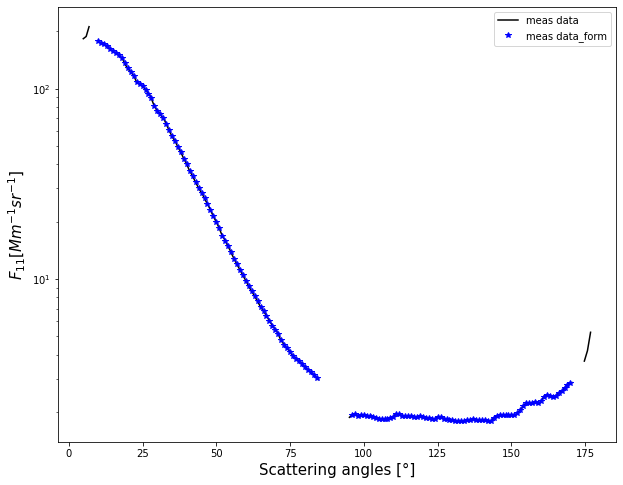

In [50]:
fontsize1 = 15
plt.figure(figsize= (10,8))
plt.plot(phase_fun_meas['angles'],phase_fun_meas['P11'],'k',label = 'meas data')
#plt.plot(angles_meas_new,f_11(angles_meas_new),'b*',label = 'meas data')
plt.plot(angles_NN,phase_fun_meas_form_F11.loc[0],'b*',label = 'meas data_form')

#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_Binned (0.05-15$\mu$m)_P11P12'],'c',label = 'data GRASP Binned_P11P12')
#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_Binned (0.05-15$\mu$m)_P11'],'b',label = 'data GRASP Binned_P11')
#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_lognormal (0.05-15$\mu$m)_P11P12'],'m',label = 'data GRASP Lognormal_P11')
#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_lognormal (0.05-15$\mu$m)_P11'],'r',label = 'data GRASP Lognormal_P11')


plt.yscale('log')

plt.xlabel('Scattering angles [°]', fontsize = fontsize1)
plt.ylabel('$F_{11} [Mm^{-1}sr^{-1}$]', fontsize = fontsize1)
plt.legend()


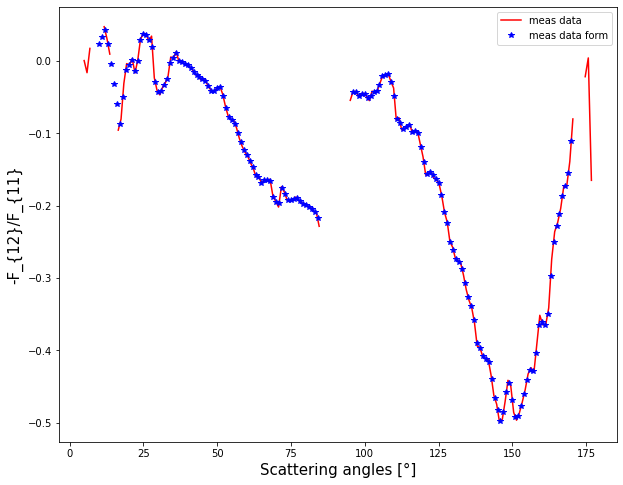

In [51]:
fontsize1 = 15
plt.figure(figsize= (10,8))
plt.plot(phase_fun_meas['angles'],phase_fun_meas['PPF'],'r',label = 'meas data')
plt.plot(angles_NN,phase_fun_meas_form_PPF.loc[0],'b*',label = 'meas data form')

#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['PPF_Binned (0.05-15$\mu$m)_P11P12'],'c',label = 'data GRASP Binned_P11P12')
#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['PPF_lognormal (0.05-15$\mu$m)_P11P12'],'m',label = 'data GRASP Lognormal_P11P12')


plt.xlabel('Scattering angles [°]', fontsize = fontsize1)
plt.ylabel('-F_{12}/F_{11}', fontsize = fontsize1)
plt.legend()

In [52]:
P11_column_names = list(filter(re.compile(".*F11").match, dvar_test.columns))
P12_column_names = list(filter(re.compile(".*PPF").match, dvar_test.columns))
P11_column_names

['F11_10',
 'F11_11',
 'F11_12',
 'F11_13',
 'F11_14',
 'F11_15',
 'F11_16',
 'F11_17',
 'F11_18',
 'F11_19',
 'F11_20',
 'F11_21',
 'F11_22',
 'F11_23',
 'F11_24',
 'F11_25',
 'F11_26',
 'F11_27',
 'F11_28',
 'F11_29',
 'F11_30',
 'F11_31',
 'F11_32',
 'F11_33',
 'F11_34',
 'F11_35',
 'F11_36',
 'F11_37',
 'F11_38',
 'F11_39',
 'F11_40',
 'F11_41',
 'F11_42',
 'F11_43',
 'F11_44',
 'F11_45',
 'F11_46',
 'F11_47',
 'F11_48',
 'F11_49',
 'F11_50',
 'F11_51',
 'F11_52',
 'F11_53',
 'F11_54',
 'F11_55',
 'F11_56',
 'F11_57',
 'F11_58',
 'F11_59',
 'F11_60',
 'F11_61',
 'F11_62',
 'F11_63',
 'F11_64',
 'F11_65',
 'F11_66',
 'F11_67',
 'F11_68',
 'F11_69',
 'F11_70',
 'F11_71',
 'F11_72',
 'F11_73',
 'F11_74',
 'F11_75',
 'F11_76',
 'F11_77',
 'F11_78',
 'F11_79',
 'F11_80',
 'F11_81',
 'F11_82',
 'F11_83',
 'F11_84',
 'F11_96',
 'F11_97',
 'F11_98',
 'F11_99',
 'F11_100',
 'F11_101',
 'F11_102',
 'F11_103',
 'F11_104',
 'F11_105',
 'F11_106',
 'F11_107',
 'F11_108',
 'F11_109',
 'F11_110',

In [53]:
np.log(phase_fun_meas_form_F11)

F11_10    F11_11   F11_12    F11_13    F11_14    F11_15    F11_16  \
0  5.180778  5.162274  5.14342  5.117309  5.091882  5.065792  5.039003   

     F11_17   F11_18    F11_19  ...   F11_161   F11_162   F11_163   F11_164  \
0  5.011476  4.97254  4.910988  ...  0.880406  0.896824  0.886325  0.872212   

    F11_165   F11_166   F11_167  F11_168   F11_169   F11_170  
0  0.891454  0.920951  0.948121  0.98563  1.025799  1.046892  

[1 rows x 150 columns]

In [54]:
# prepare the dataframes for retrieval with the different methods
phase400new5 = pd.concat([np.log(phase_fun_meas_form_F11),phase_fun_meas_form_PPF*10],axis =1)


In [55]:
phase400new5

F11_10    F11_11   F11_12    F11_13    F11_14    F11_15    F11_16  \
0  5.180778  5.162274  5.14342  5.117309  5.091882  5.065792  5.039003   

     F11_17   F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163   PPF_164  \
0  5.011476  4.97254  4.910988  ... -3.646084 -3.493157 -2.977155 -2.498932   

    PPF_165   PPF_166   PPF_167  PPF_168   PPF_169   PPF_170  
0 -2.281191 -2.115597 -1.864669 -1.73068 -1.551113 -1.104071  

[1 rows x 300 columns]

# Predict dvar from measurement data

In [56]:
#P11, PPF

phase400_scaled = phase400new5.copy()
phase400_scaled


F11_10    F11_11   F11_12    F11_13    F11_14    F11_15    F11_16  \
0  5.180778  5.162274  5.14342  5.117309  5.091882  5.065792  5.039003   

     F11_17   F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163   PPF_164  \
0  5.011476  4.97254  4.910988  ... -3.646084 -3.493157 -2.977155 -2.498932   

    PPF_165   PPF_166   PPF_167  PPF_168   PPF_169   PPF_170  
0 -2.281191 -2.115597 -1.864669 -1.73068 -1.551113 -1.104071  

[1 rows x 300 columns]

In [57]:
dvar_pred_scaled = surr.sample(phase400_scaled.values.reshape(1,-1), batch_size = 8)
dvar_pred_scaled = pd.DataFrame(data=dvar_pred_scaled, columns=qoi_test.columns)



In [58]:
dvar_pred_scaled

Vtot  RmedianV       GSD         n         k
0  2.787726  5.721332  1.126816  1.453671  0.118547

In [59]:

qoi_pred_test = surr.predict(dvar_pred_scaled)

In [60]:
dvar_pred = dvar_pred_scaled.copy()
dvar_pred['Vtot'] = np.exp(dvar_pred['Vtot'])
dvar_pred['RmedianV'] = np.exp(dvar_pred['RmedianV'])

In [61]:
dvar_pred

Vtot    RmedianV       GSD         n         k
0  16.244037  305.311415  1.126816  1.453671  0.118547

In [62]:
qoi_pred_test = pd.DataFrame(qoi_pred_test, columns = phase400_scaled.columns)

In [63]:
qoi_pred_test1 = pd.read_hdf('/data/project/general/aerosolretriev/aerosol_results_september_2022/forward_models/forward_model08/test_cases_phase.h5'
, key = 'qoi')

In [64]:
qoi_pred_test1=qoi_pred_test1.loc[34]

In [65]:
qoi_pred_test1 = pd.DataFrame(qoi_pred_test1.T)

In [66]:
qoi_pred_test

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0  5.157756  3.869571  3.946115  4.017398  3.804577  3.877523  3.813479   

     F11_17    F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163   PPF_164  \
0  3.533698  3.421685  3.252738  ... -0.918757 -0.808201 -0.762523 -0.677846   

    PPF_165   PPF_166   PPF_167   PPF_168   PPF_169   PPF_170  
0 -0.588533 -0.501978 -0.383863 -0.350666 -0.261095 -0.214547  

[1 rows x 300 columns]

In [67]:
F11_list = [x for x in qoi_pred_test.columns if 'F11' in x]
PPF_list = [x for x in qoi_pred_test.columns if 'F12' in x]

In [68]:
qoi_pred_test[F11_list]

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0  5.157756  3.869571  3.946115  4.017398  3.804577  3.877523  3.813479   

     F11_17    F11_18    F11_19  ...   F11_161   F11_162  F11_163   F11_164  \
0  3.533698  3.421685  3.252738  ... -1.349855 -1.331432 -1.80265 -2.670557   

    F11_165   F11_166   F11_167   F11_168   F11_169   F11_170  
0 -1.594575 -0.693715 -1.431409 -1.488486 -1.281758 -2.006647  

[1 rows x 150 columns]

In [69]:
angles_new  = np.arange(0,180)
angles_new
angles_NN

array([ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,
        23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
        36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
        49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
        75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  96,  97,  98,
        99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
       151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
       164, 165, 166, 167, 168, 169, 170])

In [70]:
len(angles_NN)

150

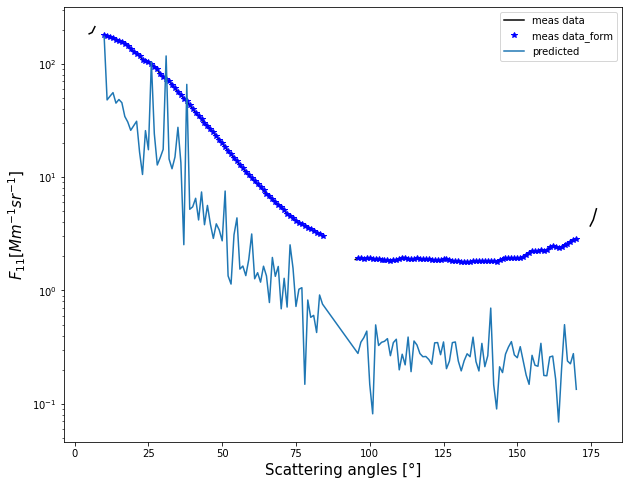

In [71]:
fontsize1 = 15
plt.figure(figsize= (10,8))
plt.plot(phase_fun_meas['angles'],phase_fun_meas['P11'],'k',label = 'meas data')
#plt.plot(angles_meas_new,f_11(angles_meas_new),'b*',label = 'meas data')
plt.plot(angles_NN,phase_fun_meas_form_F11.loc[0],'b*',label = 'meas data_form')
plt.plot(angles_NN, np.exp(qoi_pred_test[F11_list].loc[0]), label='predicted')
#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_Binned (0.05-15$\mu$m)_P11P12'],'c',label = 'data GRASP Binned_P11P12')
#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_Binned (0.05-15$\mu$m)_P11'],'b',label = 'data GRASP Binned_P11')
#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_lognormal (0.05-15$\mu$m)_P11P12'],'m',label = 'data GRASP Lognormal_P11')
#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_lognormal (0.05-15$\mu$m)_P11'],'r',label = 'data GRASP Lognormal_P11')


plt.yscale('log')

plt.xlabel('Scattering angles [°]', fontsize = fontsize1)
plt.ylabel('$F_{11} [Mm^{-1}sr^{-1}$]', fontsize = fontsize1)
plt.legend()


In [72]:
PPF_list = [x for x in qoi_pred_test.columns if 'PPF' in x]

In [73]:
qoi_pred_test[PPF_list]

PPF_10    PPF_11    PPF_12    PPF_13    PPF_14    PPF_15    PPF_16  \
0  0.161872  0.013642 -0.045883 -0.002979  0.017148 -0.051307 -0.025089   

     PPF_17    PPF_18    PPF_19  ...   PPF_161   PPF_162   PPF_163   PPF_164  \
0  0.074754  0.125005  0.096049  ... -0.918757 -0.808201 -0.762523 -0.677846   

    PPF_165   PPF_166   PPF_167   PPF_168   PPF_169   PPF_170  
0 -0.588533 -0.501978 -0.383863 -0.350666 -0.261095 -0.214547  

[1 rows x 150 columns]

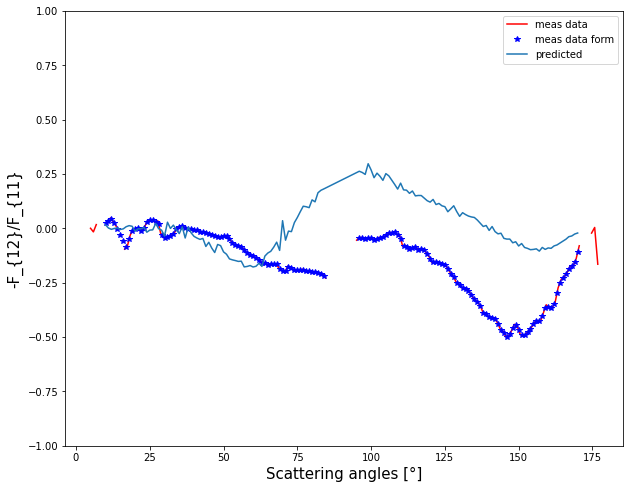

In [74]:
fontsize1 = 15
plt.figure(figsize= (10,8))
plt.plot(phase_fun_meas['angles'],phase_fun_meas['PPF'],'r',label = 'meas data')
plt.plot(angles_NN,phase_fun_meas_form_PPF.loc[0],'b*',label = 'meas data form')
plt.plot(angles_NN, qoi_pred_test[PPF_list].loc[0]/10, label='predicted')

#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['PPF_Binned (0.05-15$\mu$m)_P11P12'],'c',label = 'data GRASP Binned_P11P12')
#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['PPF_lognormal (0.05-15$\mu$m)_P11P12'],'m',label = 'data GRASP Lognormal_P11P12')


plt.xlabel('Scattering angles [°]', fontsize = fontsize1)
plt.ylabel('-F_{12}/F_{11}', fontsize = fontsize1)
plt.ylim([-1,1])
plt.legend()

# Compare to true values

In [75]:
r_vol = np.linspace(0.05,15, 500)


In [76]:
def pdf(Vtot, x, mu, sigma):
    return Vtot/(np.sqrt(2*np.pi)*np.log(sigma))*np.exp(-(np.log(x)-np.log(mu))**2.0/(2*(np.log(sigma))**2.0))

In [77]:
dvar_pred

Vtot    RmedianV       GSD         n         k
0  16.244037  305.311415  1.126816  1.453671  0.118547

In [78]:
true_size_dvar = pdf(20.406,r_vol,0.25,np.exp(0.262))

In [79]:
vol_size_dvar = pdf(dvar_pred['Vtot'].loc[0], r_vol,dvar_pred['RmedianV'].loc[0]/1000, dvar_pred['GSD'].loc[0])
                    
                    
                    

In [80]:
vol_size_meas.columns

Index(['r (um)', 'dV/dlogr'], dtype='object')

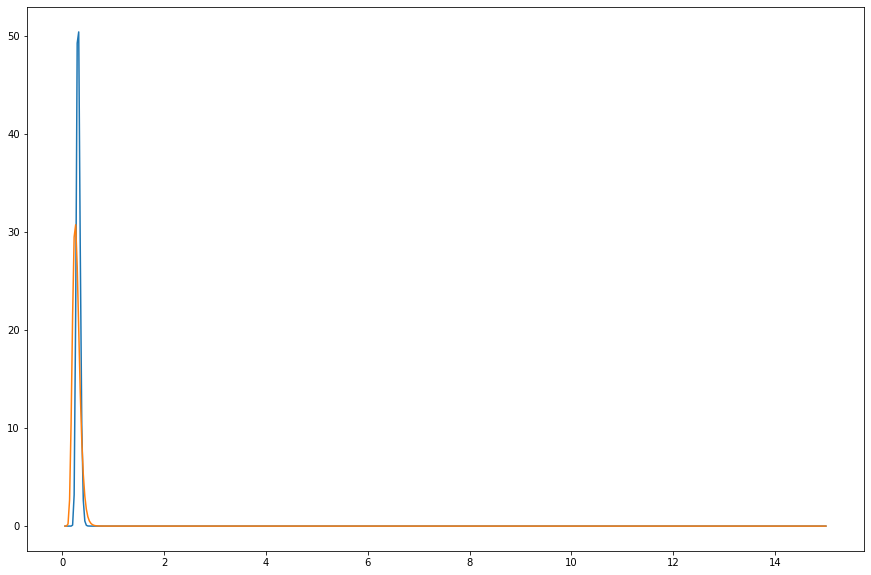

In [81]:
figure, ax = plt.subplots(1,1, figsize = [15, 10])

ax.plot(r_vol,vol_size_dvar, label='computed with FNN' )
ax.plot(r_vol,true_size_dvar, label='computed with FNN' )


In [82]:
vol_size_GRASP_log['r (um)']

0      0.05000
1      0.05727
2      0.06560
3      0.07515
4      0.08608
5      0.09860
6      0.11294
7      0.12937
8      0.14818
9      0.16974
10     0.19443
11     0.22271
12     0.25510
13     0.29221
14     0.33472
15     0.38340
16     0.43917
17     0.50305
18     0.57623
19     0.66004
20     0.75605
21     0.86603
22     0.99200
23     1.13629
24     1.30157
25     1.49089
26     1.70776
27     1.95616
28     2.24070
29     2.56663
30     2.93997
31     3.36761
32     3.85745
33     4.41855
34     5.06126
35     5.79746
36     6.64074
37     7.60669
38     8.71314
39     9.98054
40    11.43229
41    13.09520
42    14.99999
Name: r (um), dtype: float64

Text(0.5, 1.0, '$v=Vtot/(\\sqrt{2\\pi}\\log(\\sigma))*\\exp{[-(\\log(x)-\\log(\\mu))^2/(2(\\log(\\sigma))^2)]}$')

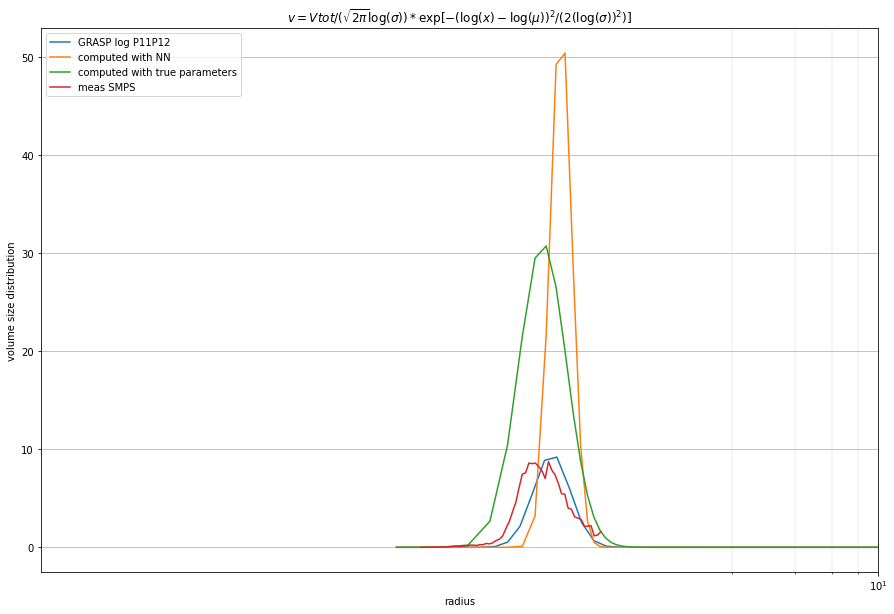

In [83]:
figure, ax = plt.subplots(1,1, figsize = [15, 10])
ax.plot(vol_size_GRASP_log['r (um)'],vol_size_GRASP_log['lognormal (0.05-15$\mu$m)_P11P12'], label = 'GRASP log P11P12')
#ax.plot(vol_size_GRASP_log['r (um)'],vol_size_GRASP_log['lognormal (0.05-15$\mu$m)_P11'], label = 'GRASP log P11P12')

ax.plot(r_vol,vol_size_dvar, label='computed with NN' )
#ax.plot(r_vol,vol_size_GRASP_P11P12_log, label='computed with GRASP_P11P12_log' )
#ax.plot(r_vol,vol_size_P11P12_INN, label='computed with rP11P12_INN' )
#ax.plot(r_vol,vol_size_P11_INN, label='computed with P11_INN' )
#ax.plot(r_vol,vol_size_P12_INN, label='computed with P12_INN' )

ax.plot(r_vol,true_size_dvar, label='computed with true parameters' )


ax.plot(vol_size_meas['r (um)'], vol_size_meas['dV/dlogr'], label="meas SMPS")






ax.set_xlim([0.001, 10])
ax.set_xscale('log')
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_minor_locator(plt.MultipleLocator(2))
ax.grid(b=True, which = 'major', linewidth = 0.75)
ax.grid(b=True, which = 'minor', linewidth = 0.25)    

ax.legend(ncol = 1, loc = 'upper left')#, bbox_to_anchor = (1,1.15), fontsize = 12)
ax.set_xlabel('radius')
ax.set_ylabel('volume size distribution')

ax.set_title('$v=Vtot/(\sqrt{2\pi}\log(\sigma))*\exp{[-(\log(x)-\log(\mu))^2/(2(\log(\sigma))^2)]}$')





In [84]:
measurements_file = '/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_october2022/uneph_data_20221017.h5'
dvar_meas = pd.read_hdf(measurements_file, key = 'param')
qoi_meas = pd.read_hdf(measurements_file, key = 'qoi')

In [85]:
for col in qoi_meas.columns:
    
    qoi_meas[col]=pd.to_numeric(qoi_meas[col])

In [86]:
qoi_meas

F11_0.532_10  F11_0.532_11  F11_0.532_12  F11_0.532_13  F11_0.532_14  \
0      10.292988     10.202447     10.157936     10.068842      9.942028   
1     319.713326    311.680040    305.246269    301.256849    291.003992   
2     171.628669    169.025406    158.073357    153.320459    158.689681   
3     255.490087    263.406212    248.650204    191.072936    193.379311   
4     169.661308    155.736160    131.068012    120.460237    113.132208   
5      11.623200     11.522790     11.485159     11.458338     11.334892   
6      31.195179     30.793104     30.730566     30.576065     30.276192   
7      69.230554     68.843726     68.329483     68.201156     67.597278   
8     150.179422    149.474910    147.978382    146.385494    144.246849   
9     123.497759    122.980150    121.288541    121.158893    119.360380   
10    241.011311    237.770535    234.895710    232.139757    228.766429   
11    188.023911    182.209560    177.159020    172.017967    166.335981   
12    356.248809    348.305503    337.111139    324.849469    316.144836   
13     97.698322     91.911165    114.354964    112.676577    101.879081   

    F11_0.532_15  F11_0.532_16  F11_0.532_17  F11_0.532_18  F11_0.532_19  ...  \
0       9.933527      9.899784      9.816825      9.784930      9.716613  ...   
1     278.475044    274.752536    273.223423    267.624397    256.391614  ...   
2     157.512209    147.067530    133.207793    114.915648    109.312189  ...   
3     192.970691    157.444078    131.005377    101.921150     72.523689  ...   
4      93.974540     71.949823     57.866504     49.493270     41.002167  ...   
5      11.293051     11.320542     11.206947     11.150377     11.141497  ...   
6      29.963659     29.745276     29.570581     29.269259     28.896808  ...   
7      66.456888     65.266585     64.066910     63.034934     62.091119  ...   
8     141.770377    139.398776    136.896733    135.392823    133.886400  ...   
9     116.715543    114.625422    112.745620    110.197502    107.388154  ...   
10    221.139446    213.688628    209.061573    206.097833    200.159731  ...   
11    162.174808    158.447923    153.780910    146.588038    139.157964  ...   
12    299.782826    292.176839    284.467388    260.428515    240.398889  ...   
13     95.227836     94.071005     90.683122     81.403601     67.999321  ...   

    PPF_0.532_161  PPF_0.532_162  PPF_0.532_163  PPF_0.532_164  PPF_0.532_165  \
0        0.062705       0.058236       0.053258       0.041816       0.041821   
1       -0.442089      -0.402139      -0.369479      -0.335306      -0.310288   
2       -0.739106      -0.691336      -0.679427      -0.630740      -0.600472   
3       -0.575264      -0.536323      -0.507552      -0.553375      -0.525443   
4       -0.522459      -0.503661      -0.471962      -0.416038      -0.316883   
5        0.081435       0.078506       0.070624       0.065684       0.061138   
6        0.143271       0.121091       0.095935       0.084857       0.076034   
7       -0.085548      -0.104193      -0.112898      -0.077543      -0.072952   
8        0.021192       0.023545       0.023041       0.017631       0.031869   
9        0.239359       0.201787       0.167051       0.162393       0.164037   
10      -0.092794      -0.076136      -0.073104      -0.087072      -0.075848   
11       0.006520       0.018406       0.006810      -0.032775      -0.008622   
12       0.129906       0.116541       0.098241       0.084517       0.102488   
13       0.047823      -0.017431      -0.018607       0.080858      -0.055929   

    PPF_0.532_166  PPF_0.532_167  PPF_0.532_168  PPF_0.532_169  PPF_0.532_170  
0        0.047582       0.038348       0.036427       0.037912       0.040365  
1       -0.296504      -0.274272      -0.237057      -0.190713      -0.155765  
2       -0.533391      -0.463790      -0.395754      -0.312426      -0.241548  
3       -0.337376      -0.288274      -0.286020      -0.250328      -0.227706  
4       -0.171938      -0.12752

In [88]:
F11list_meas = [x for x in qoi_meas if 'F11' in x]
PPFlist_meas = [x for x in qoi_meas if 'PPF' in x]


In [89]:
qoi_meas[F11list_meas]=np.log(qoi_meas[F11list_meas])
qoi_meas[PPFlist_meas]= 10*qoi_meas[PPFlist_meas]

In [90]:
dvar_meas

Vtot  RmedianV   GSD     n       k
0    0.104182  0.100463  1.04  1.59  0.0001
1    3.096041  0.251792  1.05  1.59  0.0001
2    2.812908  0.301388  1.04  1.59  0.0001
3   27.096975  0.402867  1.05  1.59  0.0001
4    52.92378  0.503584  1.05  1.59  0.0001
5    0.513611  0.076345  1.08  1.62   0.223
6    2.081532  0.117591  1.09  1.62   0.223
7    2.148818  0.152689  1.08  1.62   0.223
8    3.873357  0.178137  1.08  1.62   0.223
9    2.463627  0.192627  1.07  1.62   0.223
10   3.773135  0.229034  1.08  1.62   0.223
11    2.64638  0.264661  1.08  1.62   0.223
12    4.61805  0.304148  1.07  1.62   0.223
13  18.152857  0.352508  1.05  1.62   0.223

In [91]:
dvar_meas_pms = dvar_meas.copy()
dvar_meas_pms

Vtot  RmedianV   GSD     n       k
0    0.104182  0.100463  1.04  1.59  0.0001
1    3.096041  0.251792  1.05  1.59  0.0001
2    2.812908  0.301388  1.04  1.59  0.0001
3   27.096975  0.402867  1.05  1.59  0.0001
4    52.92378  0.503584  1.05  1.59  0.0001
5    0.513611  0.076345  1.08  1.62   0.223
6    2.081532  0.117591  1.09  1.62   0.223
7    2.148818  0.152689  1.08  1.62   0.223
8    3.873357  0.178137  1.08  1.62   0.223
9    2.463627  0.192627  1.07  1.62   0.223
10   3.773135  0.229034  1.08  1.62   0.223
11    2.64638  0.264661  1.08  1.62   0.223
12    4.61805  0.304148  1.07  1.62   0.223
13  18.152857  0.352508  1.05  1.62   0.223

In [92]:
dvar_meas_pms['RmedianV']=dvar_meas_pms['RmedianV']*1e3

In [93]:
dvar_meas_pms

Vtot    RmedianV   GSD     n       k
0    0.104182  100.462546  1.04  1.59  0.0001
1    3.096041   251.79175  1.05  1.59  0.0001
2    2.812908  301.387637  1.04  1.59  0.0001
3   27.096975  402.866801  1.05  1.59  0.0001
4    52.92378  503.583501  1.05  1.59  0.0001
5    0.513611   76.344586  1.08  1.62   0.223
6    2.081532  117.590931  1.09  1.62   0.223
7    2.148818  152.689172  1.08  1.62   0.223
8    3.873357  178.137367  1.08  1.62   0.223
9    2.463627  192.627284  1.07  1.62   0.223
10   3.773135  229.033758  1.08  1.62   0.223
11    2.64638  264.661232  1.08  1.62   0.223
12    4.61805  304.148343  1.07  1.62   0.223
13  18.152857   352.50845  1.05  1.62   0.223

In [94]:
from Pymiescatt_forward import *
qoi_pms = []
for ind in dvar_meas_pms.index:
    qoi_pms.append(pymiescatt_forward_prediction(pd.DataFrame(dvar_meas_pms.loc[ind]).T))


In [95]:
qoi_pms

[array([ 9.07262361e-02,  9.07059360e-02,  9.06450664e-02,  9.05437200e-02,
         9.04020507e-02,  9.02202737e-02,  8.99986646e-02,  8.97375591e-02,
         8.94373516e-02,  8.90984949e-02,  8.87214986e-02,  8.83069282e-02,
         8.78554035e-02,  8.73675973e-02,  8.68442334e-02,  8.62860853e-02,
         8.56939744e-02,  8.50687675e-02,  8.44113753e-02,  8.37227500e-02,
         8.30038832e-02,  8.22558034e-02,  8.14795740e-02,  8.06762905e-02,
         7.98470782e-02,  7.89930897e-02,  7.81155023e-02,  7.72155153e-02,
         7.62943476e-02,  7.53532348e-02,  7.43934268e-02,  7.34161852e-02,
         7.24227803e-02,  7.14144888e-02,  7.03925914e-02,  6.93583696e-02,
         6.83131040e-02,  6.72580710e-02,  6.61945412e-02,  6.51237764e-02,
         6.40470275e-02,  6.29655323e-02,  6.18805135e-02,  6.07931763e-02,
         5.97047066e-02,  5.86162692e-02,  5.75290054e-02,  5.64440323e-02,
         5.53624400e-02,  5.42852910e-02,  5.32136182e-02,  5.21484240e-02,
         5.1

In [96]:
name = []
for i in range(180):
    name.append('F11_'+str(i))    
for i in range(180):
    name.append('PPF_'+str(i))

In [97]:
qoi_pms = pd.DataFrame(data=qoi_pms, columns =name)

In [98]:
qoi_meas

F11_0.532_10  F11_0.532_11  F11_0.532_12  F11_0.532_13  F11_0.532_14  \
0       2.331463      2.322628      2.318255      2.309446      2.296771   
1       5.767425      5.741977      5.721119      5.707963      5.673337   
2       5.145333      5.130049      5.063059      5.032530      5.066951   
3       5.543184      5.573697      5.516047      5.252655      5.264654   
4       5.133804      5.048163      4.875716      4.791320      4.728557   
5       2.453003      2.444327      2.441056      2.438718      2.427886   
6       3.440264      3.427291      3.425258      3.420218      3.410362   
7       4.237442      4.231839      4.224341      4.222462      4.213568   
8       5.011831      5.007129      4.997066      4.986244      4.971526   
9       4.816223      4.812023      4.798172      4.797103      4.782147   
10      5.484844      5.471306      5.459142      5.447340      5.432702   
11      5.236569      5.205157      5.177048      5.147599      5.114010   
12      5.875629      5.853080      5.820413      5.783362      5.756200   
13      4.581884      4.520823      4.739307      4.724522      4.623787   

    F11_0.532_15  F11_0.532_16  F11_0.532_17  F11_0.532_18  F11_0.532_19  ...  \
0       2.295916      2.292513      2.284098      2.280843      2.273837  ...   
1       5.629328      5.615871      5.610290      5.589584      5.546706  ...   
2       5.059503      4.990892      4.891910      4.744198      4.694208  ...   
3       5.262538      5.059070      4.875238      4.624199      4.283913  ...   
4       4.543024      4.275969      4.058139      3.901837      3.713625  ...   
5       2.424188      2.426619      2.416534      2.411473      2.410677  ...   
6       3.399985      3.392670      3.386780      3.376538      3.363731  ...   
7       4.196553      4.178480      4.159928      4.143689      4.128603  ...   
8       4.954209      4.937339      4.919227      4.908180      4.896992  ...   
9       4.759740      4.741670      4.725134      4.702274      4.676450  ...   
10      5.398793      5.364520      5.342629      5.328351      5.299116  ...   
11      5.088675      5.065426      5.035529      4.987626      4.935610  ...   
12      5.703058      5.677359      5.650619      5.562328      5.482300  ...   
13      4.556272      4.544050      4.507371      4.399420      4.219498  ...   

    PPF_0.532_161  PPF_0.532_162  PPF_0.532_163  PPF_0.532_164  PPF_0.532_165  \
0        0.627052       0.582363       0.532582       0.418160       0.418215   
1       -4.420889      -4.021387      -3.694786      -3.353064      -3.102883   
2       -7.391062      -6.913360      -6.794270      -6.307399      -6.004723   
3       -5.752639      -5.363229      -5.075522      -5.533747      -5.254433   
4       -5.224594      -5.036615      -4.719624      -4.160379      -3.168828   
5        0.814355       0.785065       0.706237       0.656838       0.611383   
6        1.432710       1.210908       0.959350       0.848574       0.760335   
7       -0.855483      -1.041931      -1.128982      -0.775432      -0.729521   
8        0.211919       0.235451       0.230405       0.176313       0.318688   
9        2.393589       2.017871       1.670513       1.623926       1.640369   
10      -0.927940      -0.761357      -0.731035      -0.870718      -0.758478   
11       0.065200       0.184058       0.068097      -0.327753      -0.086217   
12       1.299060       1.165409       0.982406       0.845165       1.024880   
13       0.478233      -0.174310      -0.186067       0.808585      -0.559291   

    PPF_0.532_166  PPF_0.532_167  PPF_0.532_168  PPF_0.532_169  PPF_0.532_170  
0        0.475822       0.383483       0.364268       0.379124       0.403652  
1       -2.965038      -2.742721      -2.370565      -1.907127      -1.557648  
2       -5.333907      -4.637902      -3.957540      -3.124261      -2.415476  
3       -3.373756      -2.882741      -2.860197      -2.503285      -2.277056  
4       -1.719375      -1.27529

In [99]:
qoi_pms

F11_0       F11_1       F11_2       F11_3       F11_4       F11_5  \
0     0.090726    0.090706    0.090645    0.090544    0.090402    0.090220   
1    28.848737   28.825016   28.753966   28.635928   28.471469   28.261376   
2    33.935537   33.896002   33.777648   33.581229   33.307989   32.959656   
3   274.628323  273.932971  271.856293  268.426242  263.688814  257.707174   
4   264.585027  263.260980  259.320970  252.860363  244.034698  233.054726   
5     0.203530    0.203490    0.203370    0.203170    0.202890    0.202532   
6     2.957166    2.956377    2.954011    2.950073    2.944570    2.937511   
7     5.394362    5.392322    5.386206    5.376030    5.361817    5.343602   
8    12.965579   12.959118   12.939756   12.907551   12.862598   12.805031   
9     9.466713    9.461350    9.445277    9.418548    9.381250    9.333508   
10   18.102178   18.088036   18.045672   17.975278   17.877166   17.751773   
11   14.609246   14.593994   14.548325   14.472505   14.366971   14.232330   
12   27.531117   27.493179   27.379646   27.191368   26.929744   26.596716   
13  112.658840  112.448721  111.820424  110.780093  109.337873  107.507760   

         F11_6       F11_7       F11_8       F11_9  ...   PPF_170   PPF_171  \
0     0.089999    0.089738    0.089437    0.089098  ...  0.020634  0.016699   
1    28.006649   27.708497   27.368326   26.987729  ... -0.118788 -0.096054   
2    32.538423   32.046925   31.488217   30.865743  ... -0.193419 -0.156053   
3   250.560462  242.342300  233.159050  223.127841  ... -0.183094 -0.145947   
4   220.179717  205.709307  189.974168  173.325865  ... -0.182749 -0.142037   
5     0.202094    0.201578    0.200985    0.200315  ...  0.017701  0.014325   
6     2.928908    2.918776    2.907134    2.894002  ...  0.029202  0.023652   
7     5.321428    5.295348    5.265425    5.231728  ... -0.026258 -0.021013   
8    12.735021   12.652776   12.558537   12.452582  ...  0.016851  0.013848   
9     9.275477    9.207348    9.129343    9.041715  ...  0.048939  0.039776   
10   17.599656   17.421487   17.218047   16.990226  ... -0.004967 -0.004290   
11   14.069356   13.878977   13.662273   13.420461  ... -0.042903 -0.034172   
12   26.194738   25.726758   25.196177   24.606817  ...  0.073464  0.060050   
13  105.307404  102.757855   99.883267   96.710560  ... -0.081346 -0.064044   

     PPF_172   PPF_173   PPF_174   PPF_175   PPF_176   PPF_177   PPF_178  \
0   0.013185  0.010088  0.007407  0.005141  0.003289  0.001850  0.000822   
1  -0.075761 -0.057904 -0.042472 -0.029451 -0.018824 -0.010578 -0.004698   
2  -0.122775 -0.093592 -0.068474 -0.047370 -0.030216 -0.016951 -0.007519   
3  -0.113537 -0.085668 -0.062113 -0.042637 -0.027023 -0.015084 -0.006666   
4  -0.107929 -0.079729 -0.056743 -0.038340 -0.023988 -0.013256 -0.005817   
5   0.011309  0.008652  0.006353  0.004409  0.002821  0.001586  0.000705   
6   0.018687  0.014306  0.010510  0.007298  0.004670  0.002627  0.001167   
7  -0.016419 -0.012445 -0.009062 -0.006245 -0.003971 -0.002223 -0.000984   
8   0.011079  0.008575  0.006358  0.004449  0.002865  0.001619  0.000722   
9   0.031520  0.024191  0.017809  0.012388  0.007939  0.004470  0.001988   
10 -0.003577 -0.002865 -0.002185 -0.001564 -0.001025 -0.000587 -0.000264   
11 -0.026557 -0.020015 -0.014491 -0.009932 -0.006285 -0.003504 -0.001547   
12  0.047801  0.036817  0.027178  0.018943  0.012157  0.006852  0.003050   
13 -0.049099 -0.036455 -0.025990 -0.017548 -0.010954 -0.006035 -0.002641   

     PPF_179  
0   0.000205  
1  -0.001174  
2  -0.001877  
3  -0.001661  
4  -0.001443  
5   0.000176  
6   0.000292  
7  -0.000246  
8   0.000181  
9   0.000497  
10 -0.000067  
11 -0.000385  
12  0.000763  
13 -0.000654  

[14 rows x 360 columns]

In [100]:
dvar_meas_input = dvar_meas.copy()
#rowlist = [1,2,3,4,6,7,8,9,10,11,12,13]
#dvar_meas_input = dvar_meas_input.loc[rowlist]

In [101]:
dvar_meas_input['Vtot'] = pd.to_numeric(dvar_meas_input['Vtot'])
dvar_meas_input['RmedianV'] = pd.to_numeric(dvar_meas_input['RmedianV'])
dvar_meas_input['GSD'] = pd.to_numeric(dvar_meas_input['GSD'])
dvar_meas_input['n'] = pd.to_numeric(dvar_meas_input['n'])
dvar_meas_input['k'] = pd.to_numeric(dvar_meas_input['k'])

In [102]:
dvar_meas_input.dtypes

Vtot        float64
RmedianV    float64
GSD         float64
n           float64
k           float64
dtype: object

In [103]:

dvar_meas_input['Vtot']= np.log(dvar_meas_input['Vtot'])
dvar_meas_input['RmedianV']= np.log(dvar_meas_input['RmedianV']*1e3)

In [104]:
dvar_meas_input.describe()

Vtot   RmedianV        GSD          n          k
count  14.000000  14.000000  14.000000  14.000000  14.000000
mean    1.213456   5.374017   1.065000   1.609286   0.143393
std     1.548015   0.544143   0.017431   0.014917   0.110836
min    -2.261618   4.335257   1.040000   1.590000   0.000100
25%     0.799097   5.066942   1.050000   1.590000   0.000100
50%     1.082172   5.481236   1.070000   1.620000   0.223000
75%     1.486010   5.715236   1.080000   1.620000   0.223000
max     3.968853   6.221750   1.090000   1.620000   0.223000

In [105]:
qoi_meas =qoi_meas.drop(['F11_0.532_10','F11_0.532_85','PPF_0.532_10','PPF_0.532_85'], axis = 1)

In [106]:
F11list_meas = [x for x in qoi_meas if 'F11' in x]
PPFlist_meas = [x for x in qoi_meas if 'PPF' in x]


In [107]:
dvar_meas_pred = surr.sample(qoi_meas.values, batch_size = 8)
dvar_meas_pred = pd.DataFrame(data=dvar_meas_pred, columns=dvar_meas_input.columns)

qoi_meas_pred = surr.predict(dvar_meas_input)
qoi_meas_pred = pd.DataFrame(data= qoi_meas_pred, columns = qoi_meas.columns)

In [108]:
qoi_meas_pred_pred = surr.predict(dvar_meas_pred)
qoi_meas_pred_pred = pd.DataFrame(data= qoi_meas_pred_pred, columns = qoi_meas.columns)

In [109]:
angles_NN

array([ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,
        23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
        36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
        49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
        75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  96,  97,  98,
        99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
       151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
       164, 165, 166, 167, 168, 169, 170])

In [110]:
qoi_meas_pred

F11_0.532_11  F11_0.532_12  F11_0.532_13  F11_0.532_14  F11_0.532_15  \
0      -1.558173     -1.566744     -1.888087     -1.729564     -2.250771   
1       3.453274      3.368584      3.544610      2.922194      3.627839   
2       2.850993      2.747954      3.983515      2.198130      3.357855   
3       4.750465      4.672622      5.939602      5.043366      5.625599   
4       5.042106      4.639673      5.873038      5.483980      5.402056   
5      -0.612076     -0.572629     -0.905054     -0.490125     -1.776487   
6       0.472492      1.489520      0.422210      1.411157      0.727856   
7       1.712892      1.713879      1.591618      1.814323      1.894552   
8       2.886290      2.186721      2.577075      2.324300      2.051635   
9       2.585150      1.588385      2.370838      1.906627      1.596431   
10      3.249144      2.214264      3.024140      2.263186      2.366587   
11      3.700438      1.870033      2.522407      1.874229      2.309789   
12      4.649584      2.772094      3.018783      2.703778      3.208732   
13      5.627725      3.967990      4.235959      3.344645      4.608192   

    F11_0.532_16  F11_0.532_17  F11_0.532_18  F11_0.532_19  F11_0.532_20  ...  \
0      -1.481117     -1.605020     -1.582639     -1.659952     -1.759907  ...   
1       3.094899      3.372296      2.010858      3.654736      1.878747  ...   
2       2.715549      2.217493      1.025411      3.046037      1.954534  ...   
3       4.600763      4.193891      3.326205      5.174207      4.462706  ...   
4       4.331485      4.211801      3.611941      4.752813      4.671938  ...   
5      -0.502362     -0.343835     -0.289437     -0.411998     -0.727354  ...   
6       1.356512      1.329888      1.622106      1.333326      1.192821  ...   
7       1.809733      0.253806      1.808898      1.347157      1.651406  ...   
8       2.105720      1.617667      2.317455      1.930470      2.416063  ...   
9       1.481883      1.923769      1.938999      1.432222      2.106053  ...   
10      2.102229      3.012033      2.266575      2.063872      2.096415  ...   
11      1.702520      1.875265      1.449812      1.794537      1.244939  ...   
12      2.839010      2.308636      2.041757      2.567300      2.291327  ...   
13      4.594217      3.355676      3.117377      3.888688      3.824245  ...   

    PPF_0.532_161  PPF_0.532_162  PPF_0.532_163  PPF_0.532_164  PPF_0.532_165  \
0        0.754699       0.649858       0.550125       0.556530       0.456747   
1       -3.057875      -3.034089      -2.860824      -2.376275      -2.188819   
2       -3.684046      -3.500536      -3.195811      -2.614378      -2.325830   
3       -4.386865      -4.276019      -4.024522      -3.469961      -3.171466   
4       -3.653234      -3.736555      -3.693162      -3.436081      -3.320807   
5        0.752191       0.822982       0.694757       0.602699       0.484740   
6        0.861243       0.861039       0.740267       0.620365       0.533203   
7       -1.123043      -0.970305      -0.816875      -0.719620      -0.606414   
8        0.673822       0.625409       0.669780       0.592405       0.607110   
9        1.706007       1.485672       1.390963       1.185191       1.099947   
10       0.494656       0.397212       0.364824       0.346181       0.359828   
11      -2.676038      -2.468311      -2.267529      -2.050166      -1.725930   
12       0.148252       0.130194       0.125853       0.091596       0.173472   
13      -0.378847      -0.216195      -0.131872      -0.157836       0.006876   

    PPF_0.532_166  PPF_0.532_167  PPF_0.532_168  PPF_0.532_169  PPF_0.532_170  
0        0.450369       0.370795       0.329944       0.220183       0.194067  
1       -1.934203      -1.675696      -1.405006      -1.347733      -1.220081  
2       -2.051234      -1.714564      -1.493928      -1.440310      -1.301373  
3       -2.795944      -2.468239      -2.061047      -1.845952      -1.531623  
4       -3.069213      -2.97978

In [111]:
qoi_meas_pred_pred

F11_0.532_11  F11_0.532_12  F11_0.532_13  F11_0.532_14  F11_0.532_15  \
0       2.483085      3.231004      2.782992      3.195185      2.490820   
1       2.847729      7.088670      3.880401      5.813902      8.730300   
2       1.665942      3.399300      5.098638      1.780891      2.370370   
3       8.277717     22.062697     10.869759      8.455318     12.367847   
4       5.277141      9.157431      9.771290      3.941215      3.865284   
5       3.351648      2.725639      2.718223      2.804002      0.089260   
6       4.455681      4.662855      4.243229      4.702767      4.375227   
7       6.222566      4.986412      5.525213      5.249254      5.751080   
8       5.258004      4.568496      5.216164      4.612194      4.616929   
9       5.121347      4.550943      5.176405      4.605219      4.598769   
10      6.026310      4.676505      5.418793      4.616522      4.973346   
11      7.031126      4.873309      5.388079      4.694709      5.727284   
12     10.312007      9.707503      8.137662      5.762933     12.246789   
13      3.636907      3.527304      3.573131      2.427200      2.802773   

    F11_0.532_16  F11_0.532_17  F11_0.532_18  F11_0.532_19  F11_0.532_20  ...  \
0       3.163173      3.116139      3.430362      3.385869      3.152713  ...   
1       2.806599      2.391537      4.755086      1.653029      6.401910  ...   
2      -0.502689      0.765821     -1.152034      0.406761      2.337576  ...   
3      12.228501      8.474295     14.597192      7.568233     13.743556  ...   
4       1.291037      4.489937      1.746464      3.135453     11.160969  ...   
5       2.957844      3.707140      2.910821      3.233971      2.291368  ...   
6       4.618676      4.384527      4.633230      4.606100      4.506961  ...   
7       5.113459      4.854862      4.544753      5.324238      4.791881  ...   
8       4.257230      4.954580      4.682662      4.263038      4.838451  ...   
9       4.412256      4.957036      4.463911      4.304592      4.545031  ...   
10      4.548663      5.619533      4.540510      4.546928      4.436038  ...   
11      5.251374      4.628865      4.375098      5.031905      4.822827  ...   
12      9.796599      4.930292      7.413205      5.947103      9.152997  ...   
13      2.939451      3.024159      2.872484      2.664776      2.269564  ...   

    PPF_0.532_161  PPF_0.532_162  PPF_0.532_163  PPF_0.532_164  PPF_0.532_165  \
0        0.798118       0.857844       0.718261       0.650074       0.544370   
1       -2.785210      -2.014886      -2.899846      -2.653589      -3.140201   
2        0.664616       0.214914       0.169350       0.500331       0.085529   
3        3.087640       4.797614       3.434900       3.597756       3.123518   
4       -0.798037      -0.877638      -0.499664      -0.640307      -0.993489   
5        0.642428       0.748376       0.605061       0.497477       0.320515   
6        0.249750       0.228996       0.206627       0.186396       0.160865   
7       -1.630039      -1.452900      -1.308091      -1.149977      -0.988367   
8        2.032347       1.761068       1.558974       1.362635       1.212536   
9        1.339546       1.155216       1.056977       0.943833       0.873823   
10      -0.459633      -0.416762      -0.387540      -0.285767      -0.132088   
11       0.333715       0.290984       0.253695       0.208460       0.297854   
12       5.227771       5.074141       4.625926       3.953858       3.874688   
13       0.604912       0.595169       0.537615       0.434492       0.413625   

    PPF_0.532_166  PPF_0.532_167  PPF_0.532_168  PPF_0.532_169  PPF_0.532_170  
0        0.489609       0.448842       0.383566       0.327918       0.275249  
1       -4.074751      -4.189366      -4.176306      -4.670600      -4.553095  
2       -0.029113      -0.251214      -0.156636      -0.292407      -0.332362  
3        1.682916       2.195356       2.056147       1.484867       1.256619  
4       -1.052627      -1.04570

In [112]:
F11_pms_list = [x for x in qoi_pms.columns if 'F11' in x]

In [113]:
qoi_pms

F11_0       F11_1       F11_2       F11_3       F11_4       F11_5  \
0     0.090726    0.090706    0.090645    0.090544    0.090402    0.090220   
1    28.848737   28.825016   28.753966   28.635928   28.471469   28.261376   
2    33.935537   33.896002   33.777648   33.581229   33.307989   32.959656   
3   274.628323  273.932971  271.856293  268.426242  263.688814  257.707174   
4   264.585027  263.260980  259.320970  252.860363  244.034698  233.054726   
5     0.203530    0.203490    0.203370    0.203170    0.202890    0.202532   
6     2.957166    2.956377    2.954011    2.950073    2.944570    2.937511   
7     5.394362    5.392322    5.386206    5.376030    5.361817    5.343602   
8    12.965579   12.959118   12.939756   12.907551   12.862598   12.805031   
9     9.466713    9.461350    9.445277    9.418548    9.381250    9.333508   
10   18.102178   18.088036   18.045672   17.975278   17.877166   17.751773   
11   14.609246   14.593994   14.548325   14.472505   14.366971   14.232330   
12   27.531117   27.493179   27.379646   27.191368   26.929744   26.596716   
13  112.658840  112.448721  111.820424  110.780093  109.337873  107.507760   

         F11_6       F11_7       F11_8       F11_9  ...   PPF_170   PPF_171  \
0     0.089999    0.089738    0.089437    0.089098  ...  0.020634  0.016699   
1    28.006649   27.708497   27.368326   26.987729  ... -0.118788 -0.096054   
2    32.538423   32.046925   31.488217   30.865743  ... -0.193419 -0.156053   
3   250.560462  242.342300  233.159050  223.127841  ... -0.183094 -0.145947   
4   220.179717  205.709307  189.974168  173.325865  ... -0.182749 -0.142037   
5     0.202094    0.201578    0.200985    0.200315  ...  0.017701  0.014325   
6     2.928908    2.918776    2.907134    2.894002  ...  0.029202  0.023652   
7     5.321428    5.295348    5.265425    5.231728  ... -0.026258 -0.021013   
8    12.735021   12.652776   12.558537   12.452582  ...  0.016851  0.013848   
9     9.275477    9.207348    9.129343    9.041715  ...  0.048939  0.039776   
10   17.599656   17.421487   17.218047   16.990226  ... -0.004967 -0.004290   
11   14.069356   13.878977   13.662273   13.420461  ... -0.042903 -0.034172   
12   26.194738   25.726758   25.196177   24.606817  ...  0.073464  0.060050   
13  105.307404  102.757855   99.883267   96.710560  ... -0.081346 -0.064044   

     PPF_172   PPF_173   PPF_174   PPF_175   PPF_176   PPF_177   PPF_178  \
0   0.013185  0.010088  0.007407  0.005141  0.003289  0.001850  0.000822   
1  -0.075761 -0.057904 -0.042472 -0.029451 -0.018824 -0.010578 -0.004698   
2  -0.122775 -0.093592 -0.068474 -0.047370 -0.030216 -0.016951 -0.007519   
3  -0.113537 -0.085668 -0.062113 -0.042637 -0.027023 -0.015084 -0.006666   
4  -0.107929 -0.079729 -0.056743 -0.038340 -0.023988 -0.013256 -0.005817   
5   0.011309  0.008652  0.006353  0.004409  0.002821  0.001586  0.000705   
6   0.018687  0.014306  0.010510  0.007298  0.004670  0.002627  0.001167   
7  -0.016419 -0.012445 -0.009062 -0.006245 -0.003971 -0.002223 -0.000984   
8   0.011079  0.008575  0.006358  0.004449  0.002865  0.001619  0.000722   
9   0.031520  0.024191  0.017809  0.012388  0.007939  0.004470  0.001988   
10 -0.003577 -0.002865 -0.002185 -0.001564 -0.001025 -0.000587 -0.000264   
11 -0.026557 -0.020015 -0.014491 -0.009932 -0.006285 -0.003504 -0.001547   
12  0.047801  0.036817  0.027178  0.018943  0.012157  0.006852  0.003050   
13 -0.049099 -0.036455 -0.025990 -0.017548 -0.010954 -0.006035 -0.002641   

     PPF_179  
0   0.000205  
1  -0.001174  
2  -0.001877  
3  -0.001661  
4  -0.001443  
5   0.000176  
6   0.000292  
7  -0.000246  
8   0.000181  
9   0.000497  
10 -0.000067  
11 -0.000385  
12  0.000763  
13 -0.000654  

[14 rows x 360 columns]

In [114]:
np.arange(0,180)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179])

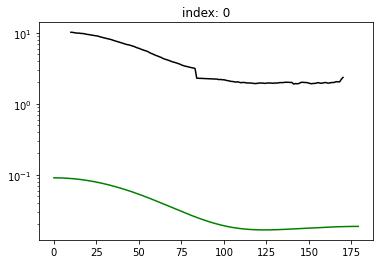

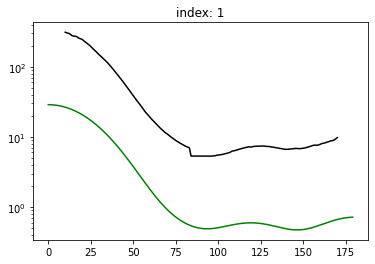

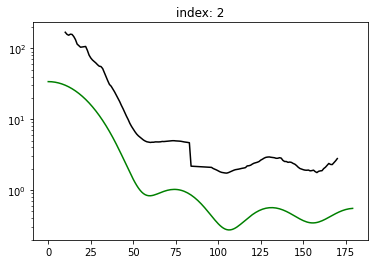

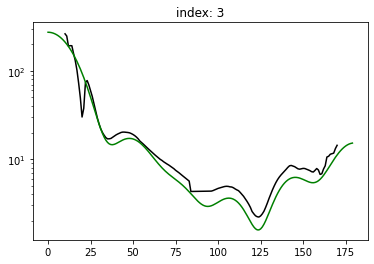

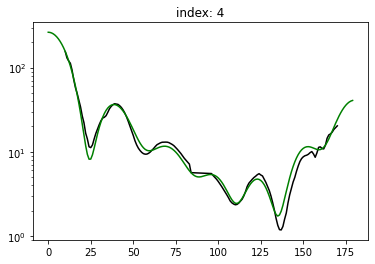

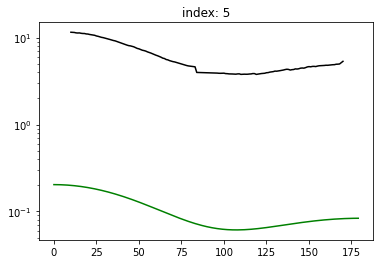

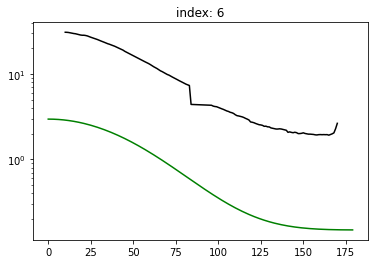

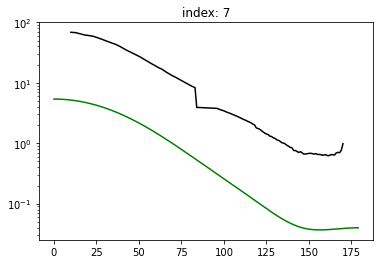

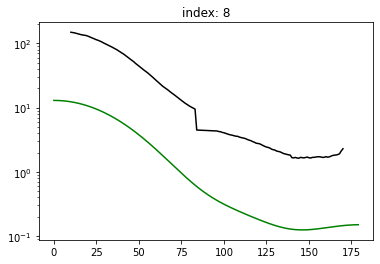

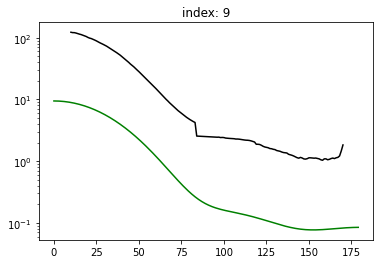

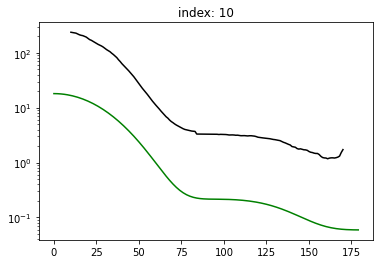

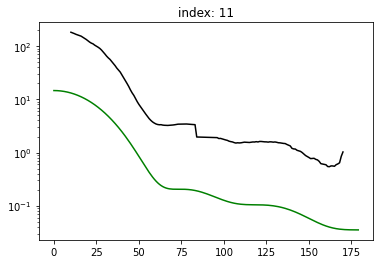

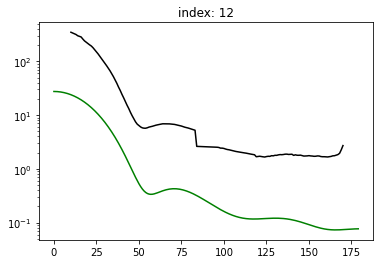

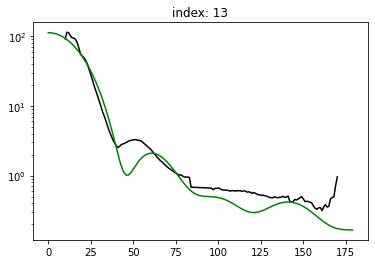

In [115]:
for ind in qoi_meas_pred.index:
    plt.figure()
    #plt.plot(angles_NN, np.exp(qoi_meas_pred[F11list_meas]).loc[ind],'r')
    #plt.plot(angles_NN, np.exp(qoi_meas_pred_pred[F11list_meas]).loc[ind],'b')
    plt.plot(angles_NN, np.exp(qoi_meas[F11list_meas]).loc[ind],'k')
    plt.plot(np.arange(0,180), qoi_pms[F11_pms_list].loc[ind],'g')
    plt.title('index: '+ str(ind))
    
    plt.yscale('log')

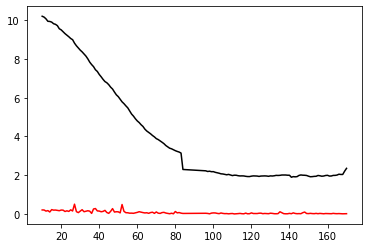

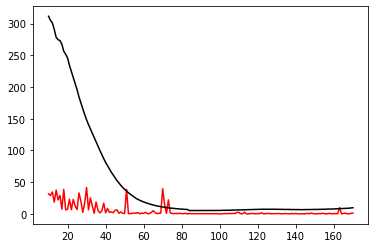

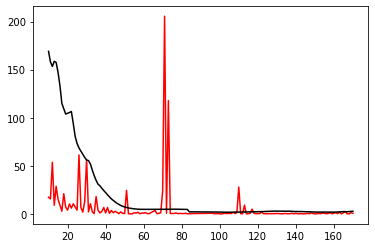

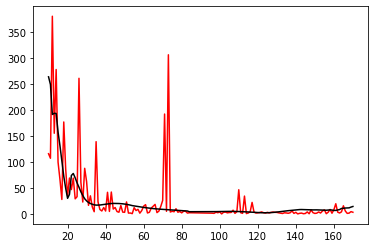

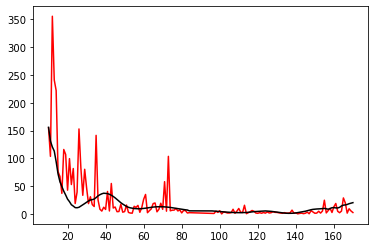

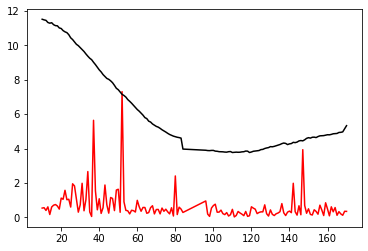

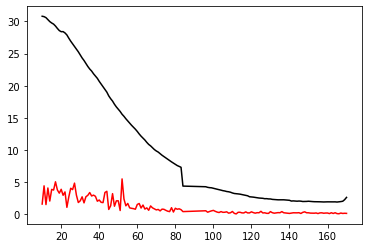

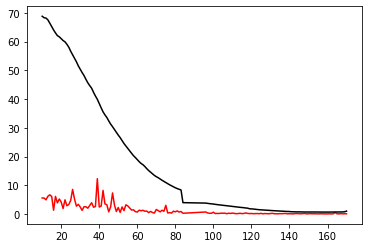

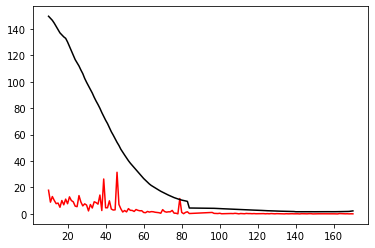

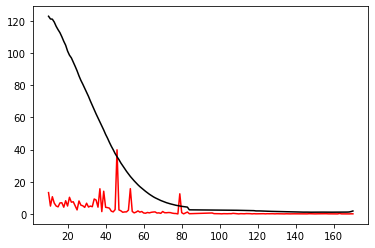

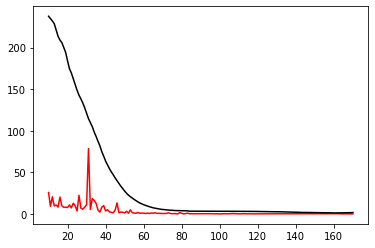

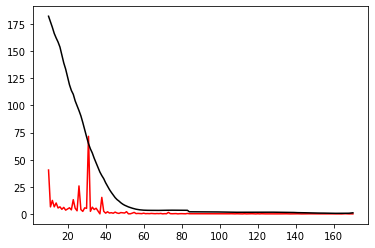

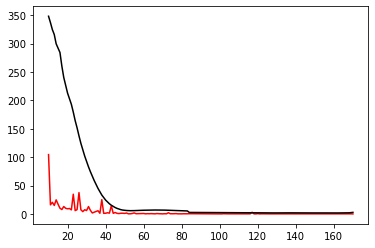

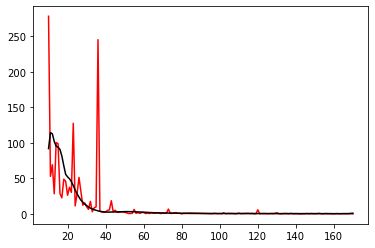

In [116]:
for ind in qoi_meas_pred.index:
    plt.figure()
    plt.plot(angles_NN, np.exp(qoi_meas_pred[F11list_meas]).loc[ind],'r')

    plt.plot(angles_NN, np.exp(qoi_meas[F11list_meas]).loc[ind],'k')

In [ ]:
dvar_meas_pred['Vtot']=np.exp(dvar_meas_pred['Vtot'])
dvar_meas_pred['RmedianV']=np.exp(dvar_meas_pred['RmedianV'])

In [ ]:
dvar_meas['RmedianV']=dvar_meas['RmedianV']*1e3

In [ ]:
for col in dvar_meas.columns:
    plt.figure()
    plt.plot(dvar_meas.index,dvar_meas[col],'*k')
    plt.plot(dvar_meas_pred.index, dvar_meas_pred[col],'*b')
    
    plt.title(col)

In [ ]:
dvar_meas

In [ ]:
dvar_meas_pred